# BAYESIAN BUDGET BERLIN
Having the budget of the city of Berlin at our disposal over several years, together with a detailed view of the demographic changes over the same years, one can ask starting questions such as whether changes in the budget for a certain category of expenses has anything to do with demographic developments. This would allow assessing the city planners' wisdom in spending tax-payer money.

In the notebook `PlanWisely`, we have explored an appreciable portion of available linear models and did not reach a satisfactory conclusion, not the least because the number of observations is small compared to the number of potential explanatory variables. Here, we will resolve this unacceptable situation and employ _Bayesian_ linear regression to solve, in particular, the problem of building our firm believe that expense per person can only be a positive number of € into our model from the beginning.

Sepcifically, we will explore which of the demographic categories
- Region of Origin
- Quality of Housing
- Age
- Duration of Residence

can best explain each of the budget categories.
- Youth
- Social

Notably, our analysis rests on a key assumption.
### Hypothesis
We presuppose that, in each budget category, there is a fixed amount of money reserved for each person in need. We further suppose that this amount does not change in time (our budget is already adjusted for inflation) and neither does it depend on which district of Berlin an individual is living in. City officials simply do not have that freedom. Trusting in the validity of these assumptions, we can then aggregate our data points over space and time to improve the ratio of observations over potential explanatory variables.

## Prelimiaries
### Import dependencies

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sbn
import pymc3             as pm

### Notebook settings

In [2]:
%matplotlib notebook

### Define function for reading a whole time series of files into a dataframe

In [3]:
def read_from_csv(path, prefix, suffix, timespan):
    file = path + prefix + str(timespan[0]) + suffix + '.csv'
    
    data = pd.read_csv(file, sep=';', decimal=',', encoding='latin-1')
    data.ZEIT = timespan[0]
    data.sort_values('RAUMID', inplace=True)
    data.reset_index(drop=True, inplace=True)
    
    years = range(timespan[0] + 1, timespan[1] + 1)

    for year in years:
        file = path + prefix + str(year) + suffix + '.csv'
    
        year_data = pd.read_csv(file, sep=';', decimal=',', encoding='latin-1')
        year_data.ZEIT = year
        year_data.sort_values('RAUMID', inplace=True)
        year_data.reset_index(drop=True, inplace=True)
        year_data.columns = data.columns
    
        data = data.append(year_data)
        
    data.drop(['PGR', 'BZR', 'PLR', 'STADTRAUM'], axis=1, inplace=True)
    data.rename(columns={'ZEIT': 'Year', 'HK_EU28': 'HK_EU27', 'BEZ': 'District'}, inplace=True)
    data = data.astype(int)
    data.reset_index(drop=True, inplace=True)
    
    return data

## Read the Data
### First the budget data ...
This has been prepared in the notebook `Budget`.

In [4]:
budget = pd.read_csv('./consolidated_2008-2015.csv')
budget.set_index(['District', 'Year'], inplace=True)

### ... then the population data

In [5]:
min_year = 2008  # minimum is 2008 because no budget data is available before that!
max_year = 2015  # maximum is 2015 becasue no demographic data is available after that!
timespan = (min_year, max_year)

path = './data/people/'

quality_of_housing = read_from_csv(path, 'WHNLAGE', '_Matrix', timespan)
duration_of_residence = read_from_csv(path, 'WHNDAUER', '_Matrix', timespan)
region_of_origin = read_from_csv(path, 'EWRMIGRA', '12H_Matrix', timespan)
age_of_all = read_from_csv(path, 'EWR', '12E_Matrix', timespan)
age_of_migrants  = read_from_csv(path, 'EWRMIGRA', '12E_Matrix', timespan)

del path
del min_year
del max_year
del timespan

## Check the Data for Consitency

#### Do the numbers of residents with different qualities of housing add up to the total number of residents?

In [6]:
(quality_of_housing.loc[:, 'WLEINFOL':'WLNZORD'].sum(axis=1) == age_of_all.E_E).all()

True

#### Do the numbers of residents with different regions of origin add up to the total number of residents?

In [7]:
(region_of_origin.loc[:, 'HK_EheJug':'HK_NZOrd'].sum(axis=1) + 
 region_of_origin.HK_EU27 == region_of_origin.MH_E).all()

True

#### Do the numbers of residents of different age add up to the total number of residents?

In [8]:
check_age_of_all = pd.DataFrame()
check_age_of_all['total'] = age_of_all.E_E
check_age_of_all['male + female'] = age_of_all.E_EM + age_of_all.E_EW
check_age_of_all['fine age groups'] = age_of_all.loc[:, 'E_E00_01':'E_E95_110'].sum(axis=1)
check_age_of_all['coarse age groups'] = age_of_all.loc[:, 'E_U1':'E_80U110'].sum(axis=1)
for index, first_column in enumerate(check_age_of_all.columns):
    for second_column in check_age_of_all.columns[index+1:]:
        print((check_age_of_all[first_column] == check_age_of_all[second_column]).all())

del check_age_of_all

True
True
True
True
True
True


#### Do the numbers of residents with migration background and of different age add up to the total number of migrants?

In [9]:
check_age_of_migrants = pd.DataFrame()
check_age_of_migrants['total'] = age_of_migrants.MH_E
check_age_of_migrants['male + female'] = age_of_migrants.MH_EM + age_of_migrants.MH_EW
check_age_of_migrants['fine age groups'] = age_of_migrants.loc[:, 'MH_E00_01':'MH_E95_110'].sum(axis=1)
check_age_of_migrants['coarse age groups'] = age_of_migrants.loc[:, 'MH_U1':'MH_80U110'].sum(axis=1)
for index, first_column in enumerate(check_age_of_migrants.columns):
    for second_column in check_age_of_migrants.columns[index+1:]:
        print((check_age_of_migrants[first_column] == check_age_of_migrants[second_column]).all()) 

del check_age_of_migrants
del first_column
del second_column

True
True
True
True
True
True


#### Do the numbers of migrants by region of origin add up to the same total as the numbers of migrants by age?

In [10]:
(region_of_origin.MH_E - age_of_migrants.MH_E == 0).all()

False

No? That is clearly inconsistent. But which are correct: the numbers for the region of origin or the number for the age of migrants?

#### Are the sums over migrants by age larger than the total number of residents anywhere at any time?

In [11]:
(age_of_all.E_E - age_of_migrants.MH_E < 0).any()

False

No? Good! So the age numbers of migrants are at least not inconsistent.

#### Are the sums over migrants by region of origin larger than the total number of residents anywhere at any time?

In [12]:
(age_of_all.E_E - region_of_origin.MH_E < 0).any()

True

Yes? So these numbers cannot be quite right. Let's have a closer look.

In [13]:
age_of_migrants[(age_of_migrants.MH_E - region_of_origin.MH_E) != 0].head()

,Year,RAUMID,District,MH_E,MH_EM,MH_EW,MH_E00_01,MH_E01_02,MH_E02_03,MH_E03_05,...,MH_E95_110,MH_U1,MH_1U6,MH_6U15,MH_15U18,MH_18U25,MH_25U55,MH_55U65,MH_65U80,MH_80U110
2935,2014,7030302,7,2537,1241,1296,24,34,27,76,...,0,24,177,276,92,209,1226,306,202,25
2936,2014,7030303,7,4833,2393,2440,86,69,73,134,...,0,86,351,616,200,427,2360,444,318,31
2937,2014,7040401,7,5785,2859,2926,74,80,94,159,...,9,74,416,643,242,510,2937,526,374,63
2938,2014,7040402,7,361,184,177,6,10,7,9,...,0,6,29,46,3,19,193,41,18,6
2939,2014,7040403,7,7721,3849,3872,134,116,114,242,...,0,134,597,935,249,623,4004,651,453,75


In [14]:
region_of_origin[(age_of_migrants.MH_E - region_of_origin.MH_E) != 0].head()

,Year,RAUMID,District,MH_E,HK_EU15,HK_EU27,HK_Polen,HK_EheJug,HK_EheSU,HK_Turk,HK_Arab,HK_Sonst,HK_NZOrd
2935,2014,7030302,7,476,55,216,122,54,30,21,64,76,15
2936,2014,7030303,7,322,59,140,47,27,18,36,18,62,21
2937,2014,7040401,7,2537,507,862,207,112,137,396,166,644,220
2938,2014,7040402,7,4833,505,1214,427,191,142,1568,244,783,691
2939,2014,7040403,7,5785,807,1727,549,284,165,1730,318,793,768


Aha! The total numbers (column *MH_E*) are there, but they are attributed to the wrong _RAUMIDs_ in the *region_of_origin* data. Let's fix that.

## Fix Inconsistencies in the Data
We reassign the inconsitent lines in the *region_of_origin* dataframe to those _RAUMDIDs_, where their total (column *MH_E*) matches that in the *age_of_migrants* dataframe.

In [15]:
wrong = region_of_origin[(age_of_migrants.MH_E - region_of_origin.MH_E) != 0]
right =  age_of_migrants[(age_of_migrants.MH_E - region_of_origin.MH_E) != 0]

for index in right.index:
    region_of_origin.loc[index] = wrong[right.MH_E[index] == wrong.MH_E].values

del wrong
del right
del index

Let's repeat the checks from above to see if there are any inconsitencies left in the data.

In [16]:
print((age_of_all.E_E - region_of_origin.MH_E < 0).any())
region_of_origin[(age_of_migrants.MH_E - region_of_origin.MH_E) != 0]

False


,Year,RAUMID,District,MH_E,HK_EU15,HK_EU27,HK_Polen,HK_EheJug,HK_EheSU,HK_Turk,HK_Arab,HK_Sonst,HK_NZOrd


No? Excellent! Let's proceed.

## Process the Data
#### Sum over _RAUMIDs_ to assembled data by district and year

In [17]:
quality_of_housing = quality_of_housing.drop('RAUMID', axis=1).groupby(['District', 'Year']).sum()
duration_of_residence = duration_of_residence.drop('RAUMID', axis=1).groupby(['District', 'Year']).sum()
region_of_origin = region_of_origin.drop('RAUMID', axis=1).groupby(['District', 'Year']).sum()
age_of_all = age_of_all.drop('RAUMID', axis=1).groupby(['District', 'Year']).sum()
age_of_migrants = age_of_migrants.drop('RAUMID', axis=1).groupby(['District', 'Year']).sum()

#### Drop unneeded columns and rename remaining ones

In [18]:
new_column_names = ['lowQuiet', 'lowNoisy', 'midQuiet', 'midNoisy', 'hiQuiet', 'hiNoisy', 'NA']
quality_of_housing.columns = pd.Index(new_column_names)

duration_of_residence.insert(loc=2, column='from5to10', 
                             value=(duration_of_residence.DAU5 - duration_of_residence.DAU10))
duration_of_residence.insert(loc=2, column='lt5', value=(age_of_all.E_E - duration_of_residence.DAU5))
duration_of_residence.drop(['EINW10', 'EINW5', 'DAU5', 'PDAU10', 'PDAU5'], axis=1, inplace=True)
duration_of_residence.rename(columns={'DAU10': 'gt10'}, inplace=True)

region_of_origin.insert(loc=2, column='dummy', 
                        value=(region_of_origin.HK_EU27 - region_of_origin.HK_EU15 - region_of_origin.HK_Polen))
region_of_origin.drop(['HK_EU27'], axis=1, inplace=True)
region_of_origin.MH_E = age_of_all.E_E - age_of_migrants.MH_E
new_column_names = ['German', 'EU15', 'EUeast', 'Polish', 'FmrJug', 'FmrSU', 'Turkish', 'Arab', 'other', 'NA']
region_of_origin.columns = pd.Index(new_column_names)

age_groups = age_of_all.copy()
total_population = age_of_all.E_E
age_of_all.drop(['E_E', 'E_EM', 'E_EW'], axis=1, inplace=True)
age_of_all.drop(age_of_all.columns[-9:], axis=1, inplace=True)
age_of_all.columns = pd.Index(['from' + column[3:].replace('_', 'to').lower() for column in age_of_all.columns])

age_groups.drop(['E_E', 'E_EM', 'E_EW'], axis=1, inplace=True)
age_groups.drop(age_groups.columns[:32], axis=1, inplace=True)
age_groups.columns = pd.Index(['from' + column[2:].replace('U', 'to').lower() for column in age_groups.columns])
age_groups.rename(columns={'fromto1': 'to1'}, inplace=True)

del new_column_names
del age_of_migrants

## Analyze the Data
### Descriptive statistics of the budget per person

In [19]:
print('YOUTH budget')
print('============')
print((budget.Youth / total_population).describe())
print('\nSOCIAL budget')
print('============')
print((budget.Social / total_population).describe())

YOUTH budget
count     96.000000
mean     444.170886
std       73.735668
min      279.331752
25%      400.346769
50%      449.242747
75%      494.924301
max      627.251207
dtype: float64

SOCIAL budget
count      96.000000
mean      860.612190
std       180.745550
min       534.702459
25%       755.246068
50%       837.410406
75%      1020.643932
max      1159.150124
dtype: float64


### Explore one-dimensional linear models
#### Chose explanatory category $X$ and budget category $y$
Why not look at the obvious thing and check which age group can best explain the projected spending on youth ...

In [20]:
X = age_groups
y = budget.Youth

X.columns.tolist()

['to1',
 'from1to6',
 'from6to15',
 'from15to18',
 'from18to25',
 'from25to55',
 'from55to65',
 'from65to80',
 'from80to110']

#### Visualize linear relationship between one component of $X$ and $y$
Pick one of the explanatory variables from the list above!

<IPython.core.display.Javascript object>


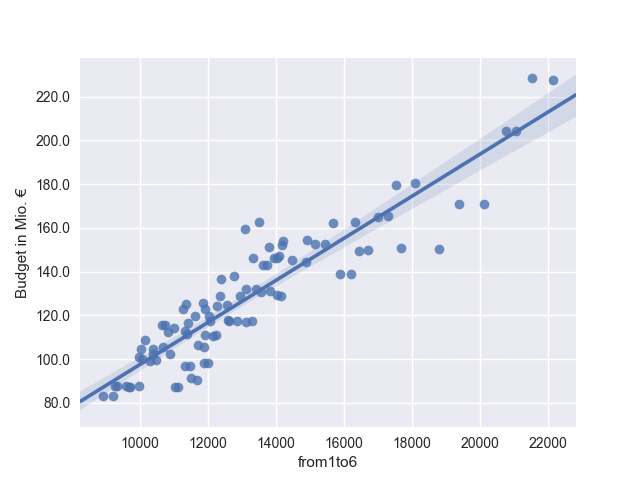

In [21]:
regressor = 'from1to6'

fig, ax = plt.subplots()
_ = sbn.regplot(regressor, y.name, X.join(y), ax=ax)
ax.set_ylabel('Budget in Mio. €')
ax.set_yticklabels(ax.get_yticks() / 10**6);

### Perform _Baysian_ linear regression
To code in our prior belief that the budget per person cannot be negative, we put _Gamma_ priors on the regression parameters (including the intercept). Furthermore, we will chose a _Student-t_ likelihood to make our regression more robust against outliers. We chose _half Normal_ priors both on its standard deviation and its degrees of freedom, because these quantities ought to be positive as well.

The hyperparameters for these priors are inspired by the descriptive statistics of the budget and the regression plot above. Most importantly, we take care not to impose any prior bias. In other words, our prior belief is that no demographic group gets more or less money than any other group.

In [22]:
X['intercept'] = 1.0

with pm.Model() as model:
    β = pm.Gamma('beta', mu=450, sd=400, shape=X.shape[1])
    σ = pm.HalfNormal('sigma', sd=1e7)
    ν = pm.HalfNormal('nu', sd=5)
    μ = β.dot(X.transpose())
    
    y_obs = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=y)
    
    trace = pm.sample(50000, init='advi_map')

Auto-assigning NUTS sampler...
Initializing NUTS using advi_map...


Optimization terminated successfully.
         Current function value: 1743.021117
         Iterations: 60
         Function evaluations: 71
         Gradient evaluations: 71


Average ELBO = -1,748.5: 100%|██████████| 200000/200000 [00:30<00:00, 6492.01it/s]
Finished [100%]: Average ELBO = -1,748.4
100%|██████████| 50000/50000 [08:26<00:00, 98.75it/s] 


#### Check the Monte-Carlo traces for irregularities

<IPython.core.display.Javascript object>


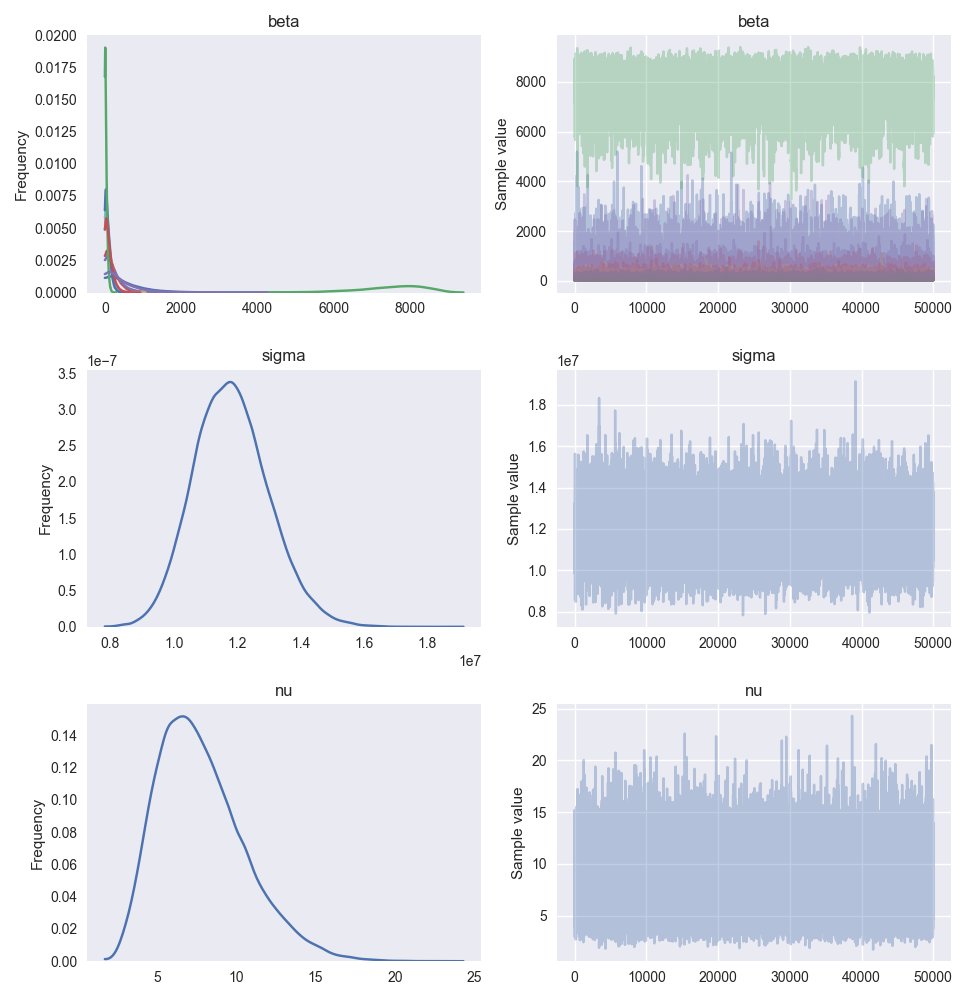

In [23]:
pm.traceplot(trace, figsize=(9.7, 10));

Looks fine.
#### Now let's plot out the posterior marginals to get a peek of the public servants' infinite wisdom in planning their budget.

<IPython.core.display.Javascript object>


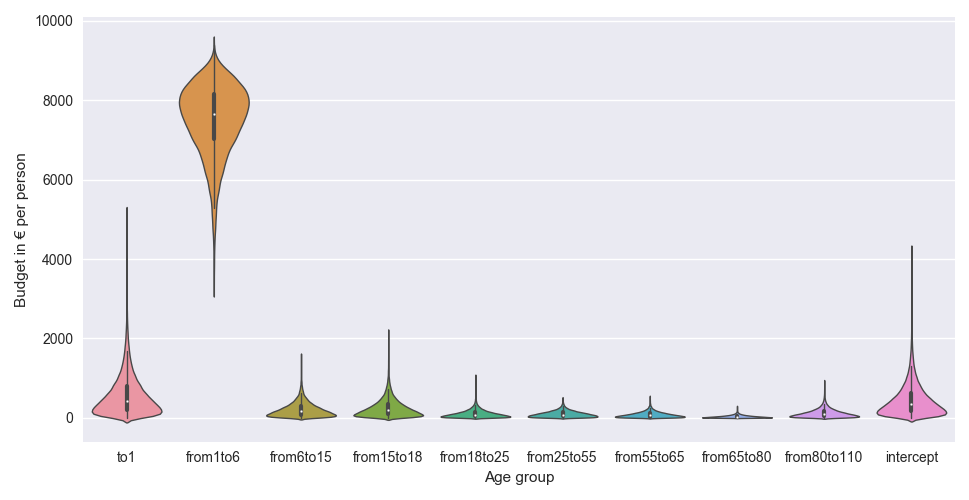

In [24]:
traces = pd.DataFrame(trace.get_values('beta'), columns=X.columns)

fig, ax = plt.subplots(figsize=(9.7, 5))
sbn.violinplot(data=traces, linewidth=1.0, scale='width', ax=ax)
ax.set_xlabel('Age group')
ax.set_ylabel('Budget in € per person')
fig.tight_layout()

Now that seems to make a lot of sense!

## Concluding Remarks
As opposed to our best efforts in the `PlanWisely` notebook, we readily obtained a probabilistic answer to our questions despite the seemingly devastating multi-colinearity between our explanantory variables. In particular, we find that the variations in the budget for youth are indeed best explained by variations in the number of 1-6 years old residents. Let's hope that the money is spent wisely.